## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [28]:
import os
import keras
import itertools
from keras.layers import Dropout # 設定 dropout
from keras.regularizers import l1_l2 # regularization
from keras.layers import BatchNormalization, Activation
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
## 載入資料
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [11]:
len(train) # 看長度可知有兩個tuple 分別是 x 和 y
len(train[0]) # 50000

50000

In [12]:
## 分割資料集
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs one-hot encoding
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

#### 做不同分類器和不同batch activation的組合，並設不同的dropout_ratio

In [19]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0, drop_ratio = 0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = Dropout(drop_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [24]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [256, 512, 1024]
Dropout_EXP = [0.1, 0.2, 0.25] 
L1_EXP = [1e-2,  1e-8,  0.0]
L2_EXP = [1e-2,  1e-8,  0.0]
# 觀察不同optimizer的有何變化
OPTIMIZER = [keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adam] 

In [17]:
list(itertools.product(L1_EXP, L2_EXP, BATCH_SIZE))

[(0.01, 0.01, 256),
 (0.01, 0.01, 512),
 (0.01, 1e-08, 256),
 (0.01, 1e-08, 512),
 (0.01, 0.0, 256),
 (0.01, 0.0, 512),
 (1e-08, 0.01, 256),
 (1e-08, 0.01, 512),
 (1e-08, 1e-08, 256),
 (1e-08, 1e-08, 512),
 (1e-08, 0.0, 256),
 (1e-08, 0.0, 512),
 (0.0, 0.01, 256),
 (0.0, 0.01, 512),
 (0.0, 1e-08, 256),
 (0.0, 1e-08, 512),
 (0.0, 0.0, 256),
 (0.0, 0.0, 512)]

In [34]:
list(enumerate(OPTIMIZER))

[(0, tensorflow.python.keras.optimizer_v2.gradient_descent.SGD),
 (1, tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop),
 (2, tensorflow.python.keras.optimizer_v2.adam.Adam)]

In [31]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, opt in enumerate(OPTIMIZER):
    # itertools.product :笛卡爾積
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (LEARNING_RATE))
    model = build_mlp(input_shape = x_train.shape[1:],  l1_ratio= L1_EXP[i], l2_ratio =  L2_EXP[i], drop_ratio = Dropout_EXP[i])
    model.summary()
    optimizer = opt(lr = LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size= BATCH_SIZE[i], 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    exp_name_tag = "combination-%s" % str(i+1)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.001000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (B

196/196 [==============================] - 4s 22ms/step - loss: 3.2233 - accuracy: 0.3760 - val_loss: 5.2942 - val_accuracy: 0.1387
Epoch 45/50
196/196 [==============================] - 4s 21ms/step - loss: 3.0441 - accuracy: 0.3812 - val_loss: 4.2550 - val_accuracy: 0.1842
Epoch 46/50
196/196 [==============================] - 4s 21ms/step - loss: 2.8865 - accuracy: 0.3820 - val_loss: 3.5099 - val_accuracy: 0.2009
Epoch 47/50
196/196 [==============================] - 4s 22ms/step - loss: 2.7428 - accuracy: 0.3863 - val_loss: 3.4909 - val_accuracy: 0.2130
Epoch 48/50
196/196 [==============================] - 4s 22ms/step - loss: 2.6259 - accuracy: 0.3839 - val_loss: 2.8300 - val_accuracy: 0.3125
Epoch 49/50
196/196 [==============================] - 4s 20ms/step - loss: 2.4998 - accuracy: 0.3904 - val_loss: 4.1460 - val_accuracy: 0.1160
Epoch 50/50
196/196 [==============================] - 4s 21ms/step - loss: 2.4112 - accuracy: 0.3913 - val_loss: 5.4563 - val_accuracy: 0.1496
Expe

Epoch 39/50
98/98 [==============================] - 4s 37ms/step - loss: 1.3274 - accuracy: 0.5217 - val_loss: 1.4956 - val_accuracy: 0.4619
Epoch 40/50
98/98 [==============================] - 4s 37ms/step - loss: 1.3221 - accuracy: 0.5257 - val_loss: 1.5378 - val_accuracy: 0.4464
Epoch 41/50
98/98 [==============================] - 4s 37ms/step - loss: 1.3074 - accuracy: 0.5302 - val_loss: 1.4386 - val_accuracy: 0.4889
Epoch 42/50
98/98 [==============================] - 4s 37ms/step - loss: 1.3114 - accuracy: 0.5298 - val_loss: 1.3953 - val_accuracy: 0.4988
Epoch 43/50
98/98 [==============================] - 4s 37ms/step - loss: 1.3006 - accuracy: 0.5323 - val_loss: 1.3828 - val_accuracy: 0.5061
Epoch 44/50
98/98 [==============================] - 4s 38ms/step - loss: 1.2925 - accuracy: 0.5384 - val_loss: 1.3766 - val_accuracy: 0.5102
Epoch 45/50
98/98 [==============================] - 4s 39ms/step - loss: 1.3016 - accuracy: 0.5336 - val_loss: 1.4643 - val_accuracy: 0.4774
Epoch 

Epoch 34/50
49/49 [==============================] - 2s 39ms/step - loss: 1.3260 - accuracy: 0.5277 - val_loss: 1.3464 - val_accuracy: 0.5205
Epoch 35/50
49/49 [==============================] - 2s 42ms/step - loss: 1.3244 - accuracy: 0.5265 - val_loss: 1.3975 - val_accuracy: 0.5085
Epoch 36/50
49/49 [==============================] - 2s 42ms/step - loss: 1.3199 - accuracy: 0.5301 - val_loss: 1.3960 - val_accuracy: 0.5037
Epoch 37/50
49/49 [==============================] - ETA: 0s - loss: 1.3230 - accuracy: 0.5272

ResourceExhaustedError:  OOM when allocating tensor with shape[1024,3072] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_65699]

Function call stack:
test_function


In [33]:
results

{'combination-1': {'train-loss': [398.3344421386719,
   362.5519104003906,
   328.79327392578125,
   296.8919677734375,
   266.8309326171875,
   238.5798797607422,
   212.1387939453125,
   187.489013671875,
   164.60765075683594,
   143.50552368164062,
   124.18383026123047,
   106.62461853027344,
   90.8350830078125,
   76.8173828125,
   64.54781341552734,
   54.07316589355469,
   45.372806549072266,
   38.433448791503906,
   33.274688720703125,
   29.737916946411133,
   27.277809143066406,
   25.18121910095215,
   23.222322463989258,
   21.383424758911133,
   19.625844955444336,
   17.988943099975586,
   16.420154571533203,
   14.942307472229004,
   13.549886703491211,
   12.278406143188477,
   11.08609390258789,
   9.9508056640625,
   8.93092155456543,
   7.997528553009033,
   7.1574883460998535,
   6.392171859741211,
   5.716958522796631,
   5.155257701873779,
   4.646552085876465,
   4.2316999435424805,
   3.889296054840088,
   3.630702257156372,
   3.4141077995300293,
   3.223267

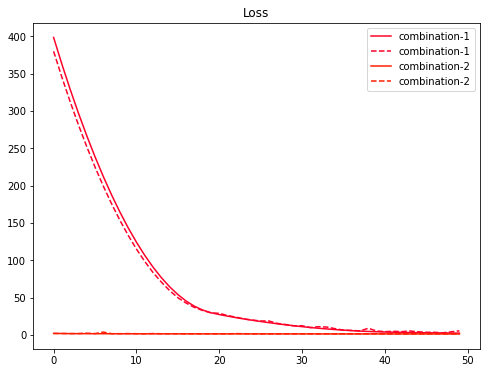

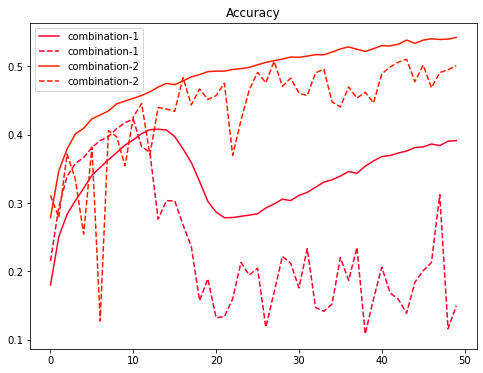

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()